In [1]:
import time
import os
import argparse

%load_ext autoreload
%autoreload 2

from varmintv2.geometry.cell2d import construct_cell2D, generate_bertoldi_radii, UnitCell2D
from varmintv2.geometry.elements import IsoparametricQuad2D, Patch2D
from varmintv2.geometry.geometry import Geometry, SingleElementGeometry
from varmintv2.geometry import bsplines

from varmintv2.physics.constitutive import NeoHookean2D, LinearElastic2D
from varmintv2.physics.materials import Material
from varmintv2.solver.discretize import HamiltonianStepper
from varmintv2.utils.movie_utils import create_movie, create_static_image, plot_ctrl
from varmintv2.solver.optimization import DenseNewtonSolver, SparseNewtonSolver

import varmintv2.utils.analysis_utils as autils
import varmintv2.utils.experiment_utils as eutils

import scipy.optimize
from scipy.spatial import KDTree

import numpy.random as npr
import numpy as onp
import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt

# Let's do 64-bit. Does not seem to degrade performance much.
from jax.config import config
config.update("jax_enable_x64", True)

/n/fs/mm-iga/miniconda3/envs/igaconda38/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/n/fs/mm-iga/miniconda3/envs/igaconda38/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
def gen_cell(corners, num_ctrl, radius):
    center = jnp.mean(corners, axis=0)

    # Generate 4 patches manually
    ctrl = []

    # Left
    corner1 = corners[0]
    corner2 = corners[1]

    angles = np.linspace(-3*np.pi/4, -5*np.pi/4, num_ctrl)
    right_perim = jnp.linspace(corner1, corner2, num_ctrl)
    left_perim = center + radius * np.stack((np.cos(angles), np.sin(angles)), axis=-1)

    ctrl.append(jnp.linspace(left_perim, right_perim, num_ctrl))

    # Top
    corner1 = corners[1]
    corner2 = corners[2]

    angles = np.linspace(-5*np.pi/4, -7*np.pi/4, num_ctrl)
    right_perim = jnp.linspace(corner1, corner2, num_ctrl)
    left_perim = center + radius * np.stack((np.cos(angles), np.sin(angles)), axis=-1)

    ctrl.append(jnp.linspace(left_perim, right_perim, num_ctrl))

    # Right
    corner1 = corners[2]
    corner2 = corners[3]

    angles = np.linspace(-7*np.pi/4, -9*np.pi/4, num_ctrl)
    right_perim = jnp.linspace(corner1, corner2, num_ctrl)
    left_perim = center + radius * np.stack((np.cos(angles), np.sin(angles)), axis=-1)

    ctrl.append(jnp.linspace(left_perim, right_perim, num_ctrl))

    # Bottom
    corner1 = corners[3]
    corner2 = corners[0]

    angles = np.linspace(-9*np.pi/4, -11*np.pi/4, num_ctrl)
    right_perim = jnp.linspace(corner1, corner2, num_ctrl)
    left_perim = center + radius * np.stack((np.cos(angles), np.sin(angles)), axis=-1)

    ctrl.append(jnp.linspace(left_perim, right_perim, num_ctrl))

    return jnp.stack(ctrl, axis=0)

In [28]:
spline_degree = 1
patch_ncp = 15

l_x = 10.0
l_y = 5.0
radius = 1.0

corners = np.array([
    [0.0, 0.0],
    [0.0, l_y],
    [l_x, l_y],
    [l_x, 0.0],
])

ctrls = gen_cell(corners, patch_ncp, radius)

In [29]:
class Steel(Material):
    _E = 200.0  # GPa
    _nu = 0.3
    _density = 7.85  # g / cm^3

mat = LinearElastic2D(Steel)
#mat = NeoHookean2D(Steel)

In [30]:
flat_ctrls = ctrls.reshape((-1, 2))
print('Finding constraints.')
kdtree = KDTree(flat_ctrls)
constraints = kdtree.query_pairs(1e-14)
constraints = onp.array(list(constraints))
print('\tDone.')

group_1 = onp.abs(ctrls[..., 0] - 0.0) < 1e-14
group_2 = onp.abs(ctrls[..., 0] - l_x) < 1e-10

dirichlet_groups = {
    '1': group_1,
    '2': group_2,
}

traction_groups = {
    # empty
}

quad_degree = 10

xknots = bsplines.default_knots(spline_degree, patch_ncp)
yknots = bsplines.default_knots(spline_degree, patch_ncp)

element = Patch2D(xknots, yknots, spline_degree, quad_degree)

cell = SingleElementGeometry(
    element=element,
    material=mat,
    init_ctrl=ctrls,
    constraints=(constraints[:, 0], constraints[:, 1]),
    dirichlet_labels=dirichlet_groups,
    traction_labels=traction_groups,
)

Finding constraints.
	Done.


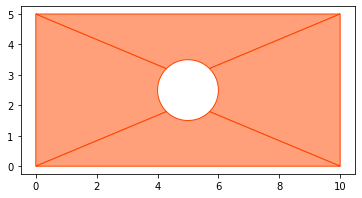

In [31]:
ax = plt.gca()
ax.set_aspect('equal')

plot_ctrl(ax, element, ctrls)

In [32]:
ref_ctrl = ctrls
potential_energy_fn = cell.get_potential_energy_fn(ref_ctrl)
strain_energy_fn = jax.jit(cell.get_strain_energy_fn(ref_ctrl))

grad_potential_energy_fn = jax.grad(potential_energy_fn)
hess_potential_energy_fn = jax.hessian(potential_energy_fn)

potential_energy_fn = jax.jit(potential_energy_fn)
grad_potential_energy_fn = jax.jit(grad_potential_energy_fn)
hess_potential_energy_fn = jax.jit(hess_potential_energy_fn)

l2g, g2l = cell.get_global_local_maps()
curr_g_pos = l2g(ref_ctrl)
print(f"{curr_g_pos.size} global degrees of freedom.")

1620 global degrees of freedom.


In [33]:
d_x = 1.0

fixed_displacements = {
    '1': onp.array([0.0, 0.0]),
    '2': onp.array([d_x, 0.0]),
}

tractions = {}

fixed_locs = cell.fixed_locs_from_dict(ref_ctrl, fixed_displacements)
tractions = cell.tractions_from_dict(tractions)

In [34]:
print(f'Starting optimization.')
opt_start = time.time()
optimizer = SparseNewtonSolver(cell, potential_energy_fn, max_iter=100, step_size=1.0)
new_x, success = optimizer.optimize(curr_g_pos, (fixed_locs, tractions))
if not success:
    print(f'Optimization reached max iters.')
else:
    print(f'Optimization succeeded')
print(f'Took {time.time() - opt_start} seconds.')

Starting optimization.
Optimization succeeded
Took 10.582305908203125 seconds.


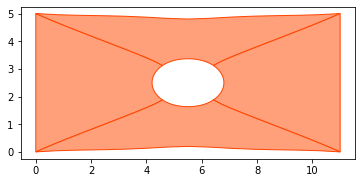

In [35]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.set_aspect('equal')

plot_ctrl(ax, element, g2l(new_x, fixed_locs))

In [36]:
map_fn, stress_fn = cell.get_stress_field_fn()

In [37]:
points = map_fn(ref_ctrl).reshape(-1, 2)
stress = stress_fn(ref_ctrl, g2l(new_x, fixed_locs)).reshape(-1, 2, 2)

s = stress - 1.0/3 * onp.trace(stress, axis1=-2, axis2=-1)[:, None, None] * onp.eye(2)
von_Mises = onp.sqrt(3./2 * onp.einsum('ijk,ijk->i', s, s))

def stress_at(point):
    ind = onp.argmin(onp.linalg.norm(points - point, axis=-1))
    return von_Mises[ind]

def deformation_at(point):
    ind = onp.argmin(onp.linalg.norm(ref_ctrl.reshape((-1, 2)) - point, axis=-1))
    return g2l(new_x, fixed_locs).reshape((-1, 2))[ind] - ref_ctrl.reshape((-1, 2))[ind]

def ref_at(point):
    ind = onp.argmin(onp.linalg.norm(ref_ctrl.reshape((-1, 2)) - point, axis=-1))
    return ref_ctrl.reshape((-1, 2))[ind]

In [38]:
ref_at(np.array([5, 3.5]))

DeviceArray([5. , 3.5], dtype=float64)

In [39]:
print(deformation_at(np.array([5., 3.5])))
print(deformation_at(np.array([5., 5.])))
print(deformation_at(np.array([5., 0.])))
print(deformation_at(np.array([4., 2.5])))

[ 0.5        -0.13329594]
[ 0.5        -0.19890161]
[0.5        0.19890161]
[2.00808601e-01 1.77635684e-15]


In [40]:
print(np.linalg.norm(deformation_at(np.array([5., 3.5]))))
print(np.linalg.norm(deformation_at(np.array([5., 5.]))))
print(np.linalg.norm(deformation_at(np.array([5., 0.]))))
print(np.linalg.norm(deformation_at(np.array([4., 2.5]))))

0.5174628565088792
0.5381095167981859
0.5381095167981915
0.20080860089278918


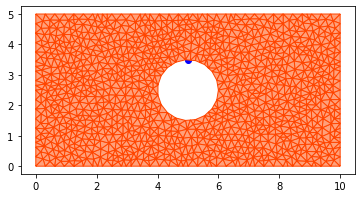

In [22]:
ax = plt.gca()
ax.set_aspect('equal')

plot_ctrl(ax, element, ref_ctrl)
ax.scatter(points[24169, 0], points[24169, 1], c='blue')
ax.scatter(points[1490, 0], points[1490, 1], c='green')

In [25]:
von_Mises[9850]

21216.986256284803

In [9]:
g_x = g2l(new_x, fixed_locs)

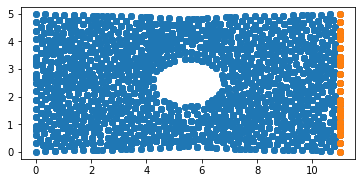

In [10]:
plt.gca().set_aspect('equal')
plt.scatter(g_x.reshape(-1, 2)[:, 0], g_x.reshape(-1, 2)[:, 1])

plt.scatter(g_x[group_2][:, 0], g_x[group_2][:, 1])

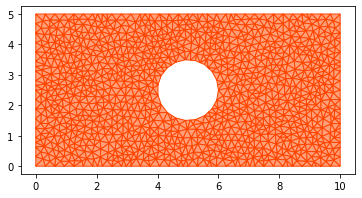

In [12]:
#plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.set_aspect('equal')

plot_ctrl(ax, element, ref_ctrl)

In [ ]:
import scipy.interpolate

xmin = onp.min(points[:, 0])
xmax = onp.max(points[:, 0])
ymin = onp.min(points[:, 1])
ymax = onp.max(points[:, 1])

xx = onp.linspace(xmin, xmax, 100)
yy = onp.linspace(ymin, ymax, 100)

gridpoints = onp.stack(onp.meshgrid(xx, yy), axis=-1)
vals = scipy.interpolate.griddata(points, von_Mises, gridpoints)

plt.gca().set_aspect('equal')
plt.contourf(xx, yy, c=vals)